# Use social data to identify drivers of online conversations about banks

### Introduction of this project
Dialogues on social media can provide tremendous insights into the behaviors, desires, pains, and thoughts of consumers. In this project, we developed a repeatable process that identifies, classifies, and extracts the sentiments under consumer financial conversations and comments in social media data. We will be serving as a public sentiment mornitoring agency with the mission of mornitoring sentiments on different banks so as to provide insights on marketing and bank reputation.

##### Dataset

Data is acquired from Wells Fargo Campus Analytics Challenge:

https://www.mindsumo.com/contests/wells-fargo


The dataset contains 6 columns. 
The first column is Auto-incremented AutoID (trackeach Social Media comment). The second column is the date that the comment was submitted to the social media venue. The third and fourth column contain Year Month that the comment was generated, which are redundant (both can be generated from the date column). The fifth column is MediaType - the type of Social Media source: either Twitter or Facebook in this data set. The last column is FullText - full text of the submitted comment, which is the most important data for our analysis.

It contains 220377 records of Twitter data (8/2015) and Facebook data (8/2014 - 8/2015)

##### Approach

Our approach to the problem is a four-step process:

Part 1. Exploratory Data Analysis on text data:

1. Clean data by removing irrelevant messages and useless common words resulting from data preprocessing (i.e. NAME, ADDRESS).
2. Identify main topics being discussed by creating bigram collocations.

Part 2. Sentiment Analysis on different topics:

3. Look at most commonly occurring tokens, as well as frequently occurring bigrams and trigrams.
4. Analyze conversation sentiments across time.


# Part 1 - Exploratory Data Analysis
### Data Preprocessing
Clean data by removing irrelevant messages and useless common words resulting from data preprocessing

#### Import Text Processing Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import nltk
#corpus: library of the words 
from nltk.corpus import stopwords, brown
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from sklearn.feature_extraction.text import CountVectorizer

#### Open file and read

In [2]:
def open_corpus(file):
    with open(file) as f:
        raw_text = f.read()
    return raw_text

#### Define Text Processing Functions

In [3]:
#tokennize the word in text
def tokenize_sents(raw_text):
    raw_sents = nltk.sent_tokenize(raw_text)
    return [nltk.word_tokenize(word) for word in raw_sents]

def tokenize_words(raw_text):
    return nltk.word_tokenize(raw_text)

#brown: English environments library
def create_data_sets():
    tagged_sents = brown.tagged_sents(categories='news')
    size = int(len(tagged_sents) * 0.9)
    train_sents = tagged_sents[:size]
    test_sents = tagged_sents[size:]
    return train_sents, test_sents

def create_backoff_tagger(): 
    train_sents, test_sents = create_data_sets()
    t0 = nltk.DefaultTagger('NN')
    t1 = nltk.UnigramTagger(train_sents, backoff=t0)
    t2 = nltk.BigramTagger(train_sents, backoff=t1)
    return t2

#### Load data from CSV to Pandas DataFrame

In [4]:
dataset = pd.read_csv("dataset.txt", delimiter="|", encoding="latin-1", index_col="AutoID")
dataset.head()

,Date,Year,Month,MediaType,FullText
AutoID,,,,,
1,8/26/2015,2015,8,twitter,3 ways the internet of things will change Bank...
2,8/5/2015,2015,8,twitter,BankB BankB Name downgrades apple stock to neu...
3,8/12/2015,2015,8,twitter,BankB returns to profit on INTERNET/! board2? ...
4,8/5/2015,2015,8,twitter,BankB tells advisers to exit paulson hedge fun...
5,8/12/2015,2015,8,twitter,BankC may plead guilty over foreign exchange p...


In [5]:
dataset.shape

(220377, 5)

We opted to focus primarily on the Facebook data for a few reasons:
* It covers a longer time period, 12 months versus one month
* The messages were longer and more resembled coherent, english thoughts
* We did not have the ability to find Twitter messages that spanned across several tweets by a single user

#### Filter to Facebook messages only


In [6]:
facebook = dataset[dataset['MediaType'] == 'facebook']

#### Identify stopwords and remove irrelevant messages


In [7]:
facebook.head()

,Date,Year,Month,MediaType,FullText
AutoID,,,,,
56,9/30/2014,2014,9,facebook,laude Name BankB in the line up when the# fly...
65,1/9/2015,2015,1,facebook,- any body banking with BankC bank bank tryna ...
66,8/19/2014,2014,8,facebook,- bitches be thoting off Name Name me Name Nam...
67,10/12/2014,2014,10,facebook,- center for aligned healing special announcem...
69,8/20/2014,2014,8,facebook,- facebook wife wife?   :- *      ¥ ...


In [8]:
facebook.shape

(83647, 5)

#### 1. Include only unique messages

Many messages had the same text as other messages in the dataset. All duplicate messages were removed.

In [9]:
prune1 = []
msgs = set()#no repeatable item only unique remains
#go through every msg
for item in facebook['FullText']:
    if item not in msgs:
        msgs.add(item)
        prune1.append(item)
        
print('Messages Remaining:', len(prune1))

Messages Remaining: 80699


#### 2. Remove all tweets that cannot be attributed to a bank

If no mentions or hashtags for banks A-D were present in a message, it was
removed in this prune.

In [10]:
##
bank_words = ['BankA', 'BankB', 'BankC', 'BankD', '#BankA', '#BankB', '#BankC', '#BankD']
prune2 = []
for item in prune1:
    if any(item for word in bank_words):
        prune2.append(item)

print('Messages Remaining:', len(prune2))

Messages Remaining: 80699


#### 3. Remove messages of banks responding to customers

In [11]:
##
prune3 = []
for item in prune2:
    if 'Name_Resp' not in item:
        prune3.append(item)
print('Messages Remaining:',len(prune3))

Messages Remaining: 80247


#### 4. Remove messages from employees and interview candidates

In [12]:
interview_words = ['interview', 'interviews', 'got the job', 'hiring at', 'hired']
prune4 = []
for item in prune3:
    if all(word not in item for word in interview_words):
        prune4.append(item)
print('Messages Remaining:',len(prune4))  

Messages Remaining: 79621


#### 5. Remove messages about bank sponsored stadiums and arenas

In [13]:

sports_words = ['stadium', 'playoffs', 'arena', 'preseason', 'center for the arts', 'BankA center', 'BankA building', 'game day']
prune5 = []
for item in prune4:
    if all(word not in item for word in sports_words):
        prune5.append(item)
print('Messages Remaining:',len(prune5))

Messages Remaining: 76614


#### 6. Remove spam messages about 'mission main street'

In [14]:
prune6 = []
for item in prune5:
    if 'mission main street' not in item:
        prune6.append(item)
print('Messages Remaining:',len(prune6))

Messages Remaining: 71009


#### 7. Remove messages for #getcollegeready contest

In [15]:
prune7 = []
for item in prune6:
    if 'getcollegeready' not in item:
        prune7.append(item)
    else:
        print(item)
print('Messages Remaining:',len(prune7))

a single BankB pack could help you# getcollegeready. Name tuned for the Name event college dreams are made of.
here are a few tips for making the most out of your student budget: INTERNET# getcollegeready
need help sorting out finances for college? make an appointment to speak with a banker today: INTERNET# getcollegeready
Messages Remaining: 71006


#### 8. Clean text by defining functions

In [16]:
# Additional cleaning.
import re
import string
def tokenize(text):
    punc_re = '[' + re.escape(string.punctuation) + ']'
    text = text.lower()
    text = re.sub(r'(.)\1\1\1+', r'\1', text) 
    text = re.sub(r'[0-9]', '9', text)
    text = re.sub('bank(\S+)', 'bankabcd', text)
    text = re.sub('#bank(\S+)', '#bankabcd', text)
    toks = []
    for tok in text.split():
        tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
        tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
        for subtok in tok.split():
            if re.search('\w', subtok):
                toks.append(subtok)
    return toks
prune8 = []
for item in prune7:
    prune8.append(tokenize(item))

####  Remaining portion of Text

In [17]:
percent_remaining = (len(prune8)/len(facebook['FullText']))*100
print('Percent of tweets remaining after prune:', percent_remaining,'%')

Percent of tweets remaining after prune: 84.88768276208351 %


After examining the most commonly occurring tokens in the messages, we identified two lists of Stop Words. The first, filter_stop, consisting of words that had been added to dataset by Wells Fargo as masks. The second, addl_stop, were words and characters we identified as occurring with very high frquency in messages that were of no analytical value.

In [91]:
# additional stopwords derived from examining 100 most common tokens in dataset
addl_stop = {'â', 'giannis', 'banksters', 'classwarfare', 'financialterrorists', 
             'morganstanley', 'vote', 'banke', 'BankE', 'bankE'}

In [21]:
def exclude_stop_items(row, addl_stop):
    words = tokenize_words(row)
    if [x for x in words if x in addl_stop]:
        return False
    return True

In [22]:
no_stop = facebook['FullText'].apply(lambda x: exclude_stop_items(x, addl_stop))
#this only return the text without the stop words

We can find that after excluding these items reduced the size of the dataset by about 17%.

In [23]:
facebook.shape

(83647, 5)

In [24]:
facebook[no_stop].shape

(70209, 5)

### Topic Identification

We next used a few methods to explore the remaining data for key concepts to focus on in the second half of the analysis. Below we look at most commonly occurring tokens, as well as frequently occurring bigrams and trigrams. For this section, we take about half of the total messages out of the Pandas DataFrame and into a list of lists.

In [25]:
#We only remains Half the dataset, roughly, for speed
raw_text = ' '.join(facebook[no_stop]['FullText'].tolist())[:7000000] 

In [26]:
words = tokenize_words(raw_text)

In [27]:
no_stop_list = [x for x in words if x not in stopwords.words('english') and x.isalpha()
              and x not in filter_stop]

In [28]:
#find the 10 most frequent words and their frequency
fd = nltk.FreqDist(no_stop_list)
fd.most_common(10)

[('bank', 10672),
 ('account', 5290),
 ('get', 3332),
 ('money', 3177),
 ('new', 2822),
 ('like', 2423),
 ('one', 2319),
 ('got', 2288),
 ('card', 2242),
 ('financial', 2202)]

In [29]:
words_top300 = ' '.join([word[0] for word in fd.most_common(300)])

In [30]:
words_top300 

'bank account get money new like one got card financial us business dont time today know shared go help center good day would photo people asset see anyone make need check call pay credit going banks work banking customer please service wealth thank great managers home want years thanks love million first advisers mortgage year job cash last take u chicago team never come cant rating said big news way give even marathon still free number customers use billion phone company next could settlement ever right think also well family rebanke made buy say morning someone loan getting week open deposit looking two support called let debit information much another tickets every may best n put days says happy world fraud everyone told market man keep night fuck hate find since deal breaking close tomorrow house many life better share atm tell month friends lot working fund group branch game added look contact set done trying street online state fees long data neutral photos cards didnt charge su

#### Create bigrams from messages
Since bigrams are important for our sentiment analysis, we create bigrams to find out.
While the most common tokens are interesting, they are not giving us anything specific to zero in on, so we looked at the top bigrams in terms of PMI and raw frequency. Please note, the next section runs fairly slowly.

In [31]:
finder = BigramCollocationFinder.from_words(no_stop_list)

#### Locate most common bigrams by PMI and raw frequency

In [32]:
bigram_measures = BigramAssocMeasures()
top_pmi = finder.nbest(bigram_measures.pmi, 100)

In [33]:
top_raw = finder.nbest(bigram_measures.raw_freq, 100)

In [34]:
top_pmi[:10]

[('BankAales', 'sickens'),
 ('BankAcimaginedragons', 'imaginedragons'),
 ('BankAon', 'gianormous'),
 ('BankCcreditcardmemberprivilege', 'koskinlaser'),
 ('BankCfoundation', 'financialstability'),
 ('BankCthankyoucards', 'ajhudson'),
 ('BankDdesignation', 'develeporexperience'),
 ('BankDhashumanbeingemployees', 'byebyecreditcards'),
 ('BankDhomefinance', 'thanksmonique'),
 ('BankDisntinboston', 'BankDappredesignfail')]

In [35]:
top_raw[:10]

[('financial', 'advisers'),
 ('wealth', 'managers'),
 ('advisers', 'wealth'),
 ('asset', 'financial'),
 ('bank', 'bank'),
 ('chicago', 'marathon'),
 ('customer', 'service'),
 ('bank', 'account'),
 ('debit', 'card'),
 ('shared', 'photo')]

PMI is finding too specific of topics, but the top raw bigrams seems to be working very well. We hand identified the best topics from here, then looked back to see if they shared a common tag pattern that could be used to generalize into a list of topics.

In [37]:
nltk.download('brown')  

[nltk_data] Downloading package brown to /Users/jiewei/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [38]:
tagger = create_backoff_tagger()

In [39]:
tagged_bgs = []
for bg in top_raw:
    tagged_bgs.append(tagger.tag(bg))
    
tagged_bgs[:15]

[[('financial', 'JJ'), ('advisers', 'NNS')],
 [('wealth', 'NN'), ('managers', 'NNS')],
 [('advisers', 'NNS'), ('wealth', 'NN')],
 [('asset', 'NN'), ('financial', 'JJ')],
 [('bank', 'NN'), ('bank', 'NN')],
 [('chicago', 'NN'), ('marathon', 'NN')],
 [('customer', 'NN'), ('service', 'NN')],
 [('bank', 'NN'), ('account', 'NN')],
 [('debit', 'NN'), ('card', 'NN')],
 [('shared', 'VBD'), ('photo', 'NN')],
 [('breaking', 'VBG'), ('news', 'NN')],
 [('rating', 'NN'), ('reiterated', 'VBN')],
 [('would', 'MD'), ('like', 'VB')],
 [('center', 'NN'), ('center', 'NN')],
 [('credit', 'NN'), ('card', 'NN')]]

Identify common part-of-speech patterns in useful topics


In [40]:
good_patterns = {('JJ', 'NN'),
                 ('JJ', 'NNS'),
                 ('JJT', 'NN'),
                 ('NN', 'NN'),
                 ('NN', 'NNS'),
                 ('NNS', 'VB')}

Find bigram collocations based on frequency and POS pattern


In [41]:
good_tagged_bgs = []
for bg in top_raw:
    tagged = tagger.tag(bg)
    pattern = (tagged[0][1], tagged[1][1])
    if pattern in good_patterns and tagged[0] != tagged[1]:
        good_tagged_bgs.append(tagger.tag(bg))
    
good_tagged_bgs

[[('financial', 'JJ'), ('advisers', 'NNS')],
 [('wealth', 'NN'), ('managers', 'NNS')],
 [('chicago', 'NN'), ('marathon', 'NN')],
 [('customer', 'NN'), ('service', 'NN')],
 [('bank', 'NN'), ('account', 'NN')],
 [('debit', 'NN'), ('card', 'NN')],
 [('credit', 'NN'), ('card', 'NN')],
 [('neutral', 'JJ'), ('rating', 'NN')],
 [('checking', 'NN'), ('account', 'NN')],
 [('data', 'NN'), ('breach', 'NN')],
 [('goldman', 'NN'), ('sachs', 'NN')],
 [('overweight', 'NN'), ('rating', 'NN')],
 [('gon', 'NN'), ('na', 'NN')],
 [('good', 'JJ'), ('morning', 'NN')],
 [('new', 'JJ'), ('photos', 'NN')],
 [('wan', 'NN'), ('na', 'NN')],
 [('marathon', 'NN'), ('chicago', 'NN')],
 [('close', 'JJ'), ('account', 'NN')],
 [('bank', 'NN'), ('robbery', 'NN')],
 [('small', 'JJ'), ('business', 'NN')],
 [('new', 'JJ'), ('bank', 'NN')],
 [('account', 'NN'), ('bank', 'NN')],
 [('financial', 'JJ'), ('crisis', 'NN')],
 [('worst', 'JJT'), ('bank', 'NN')],
 [('money', 'NN'), ('account', 'NN')],
 [('tickets', 'NNS'), ('see', 

In [42]:
len(good_tagged_bgs)

48

Applying the tagging reduced our total list to 48, to see what additional topics may be relevant.

# Part 2 - Sentiment Analysis on different topics
### Look at most commonly occurring word(s)
Create word clouds for the top 300 words of all banks.

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [88]:
wordcloud1 = WordCloud(background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(words_top300)

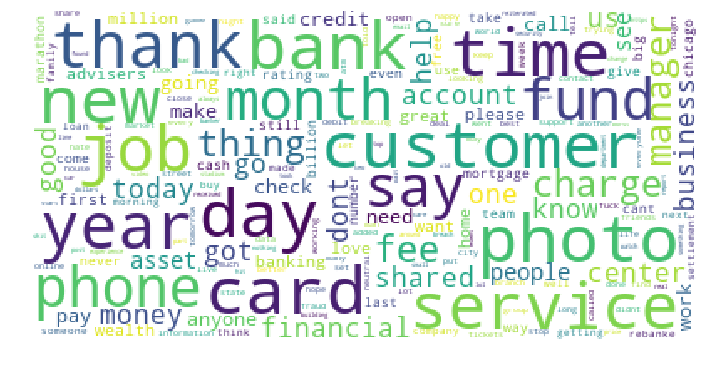

In [89]:
print(wordcloud1)
fig = plt.figure(figsize=(12,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

As we can see from the word cloud, time, customer and financial services are very important topic in this area.

In [47]:
topbiword = ' '.join([item[0]+'_'+item[1] for item in top_raw])

In [48]:
wordcloud2 = WordCloud(background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(topbiword)

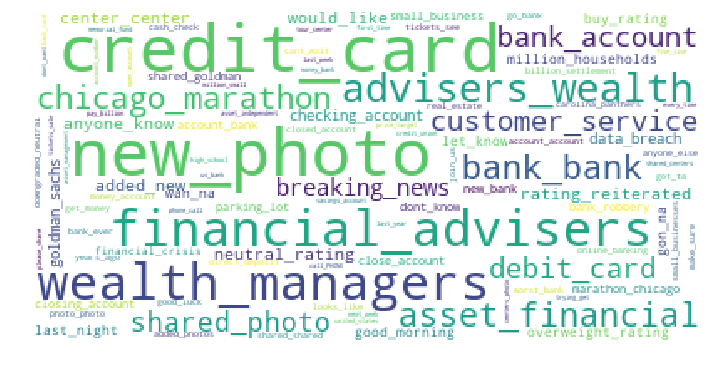

In [49]:
print(wordcloud2)
fig = plt.figure(figsize=(12,8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

From bigram and unigram wordclouds, we can see that there are both similarities and differences from each other.
Credit card is the most common bigram. Financial advisers and wealth managers are also common topics. For some reason "new photo" is also very frequent.

### Analyze conversation sentiments across time

We want to know sentiment analysis for for sepecific bank like bankB and bankA.

In [50]:
def findbankb(x):
    #filter out all the facebook message which contains banb
    if 'bankb' in x.lower():
        return True
    else:
        return False

In [51]:
#get bankB data
bankB = facebook[facebook['FullText'].apply(findbankb)]

In [53]:
from textblob import TextBlob#for sentiment analysis
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a text by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


In [54]:
def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [55]:
#create sentiment analysis column
bankB['SA'] = np.array([ analize_sentiment(tweet) for tweet in bankB['FullText']])

/Users/jiewei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


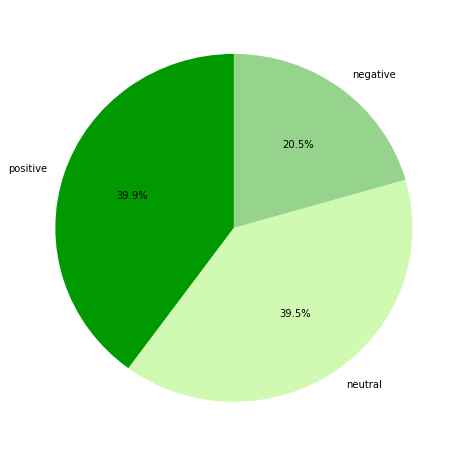

In [56]:
import matplotlib.pyplot as plt
#slices_hours = 
sa = ['positive','neutral','negative']
colors = ['#009900', '#D0F9B1', '#96D38C']
fig = plt.figure(figsize=(8,8))
plt.pie(bankB['SA'].value_counts().tolist(), labels=sa, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

# comment distribution of bankB

We can see from the pie chart that the netural and positive messages count account for almost 80% of total bankB. BankB overall has a good reputation on Facebook.

In [57]:
def findbanka(x):
    #filter out all the facebook message which contains bankb
    if 'banka' in x.lower():
        return True
    else:
        return False
bankA = facebook[facebook['FullText'].apply(findbanka)]

In [58]:
bankA['SA'] = np.array([ analize_sentiment(tweet) for tweet in bankA['FullText']])

/Users/jiewei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


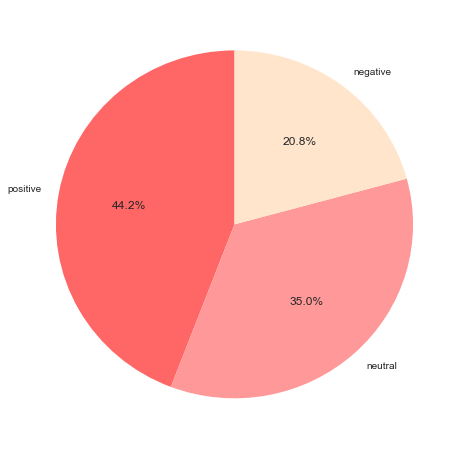

In [94]:
import matplotlib.pyplot as plt
#slices_hours = 
sa = ['positive','neutral','negative']
colors = ['#FF6666', '#FF9999', '#FFE5CC']
fig = plt.figure(figsize=(8,8))
plt.pie(bankA['SA'].value_counts().tolist(), labels=sa, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()
# comment distribution of bankB

We can see from the pie chart that the netural and positive count for almost 80% of total bankA messages. The number of positive messages is a little bit higher than bankB. Overall, BankA has a better reputation than BankB on Facebook.

In [60]:
bankA.head()

,Date,Year,Month,MediaType,FullText,SA
AutoID,,,,,,
56,9/30/2014,2014,9,facebook,laude Name BankB in the line up when the# fly...,-1
71,11/27/2014,2014,11,facebook,- finna hit BankA pick up bout 4... 0 comma 00...,0
75,9/1/2014,2014,9,facebook,- i need some neBankA riends.. who can i inbox,0
83,9/30/2014,2014,9,facebook,- interview with BankA over the phone thursday...,0
99,12/30/2014,2014,12,facebook,- BankA Name shit Name Name w/ damn$$$ Name.,-1


In [81]:
import seaborn as sns
%pylab inline
import pandas as pd
pd.set_option('colwidth', 200)

Populating the interactive namespace from numpy and matplotlib


/Users/jiewei/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [65]:
plt.figure(figsize = (15,12))
a= bankA.sort_values(by=['Month'])['Month'].value_counts()
a

12    5111
8     3608
10    3096
1     2999
9     2900
11    2364
2     2286
3     1401
4     1347
6      627
5      492
7      489
Name: Month, dtype: int64

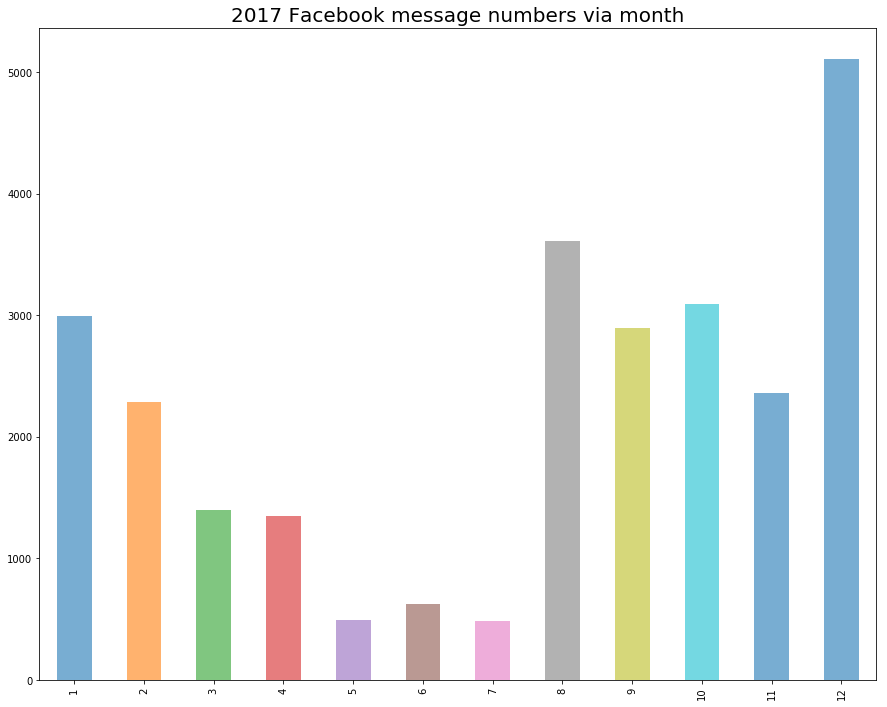

In [68]:
a.sort_index(level='months').plot(kind = 'bar',alpha=0.6)
plt.title('2017 Facebook message numbers via month',fontsize=20)
plt.show()

We can see from the plot that conversations about banks happen most during the first several months and last several months, with December having the highest counts. That is majorily because, at the end of the year, people usually spend more money on holidays, and they might need to go to banks more often. Also, people will plan their financial plans for the next year, they might look back at their bank accounts to see their financial status. Those reasons account for the largest amount of comments in December.

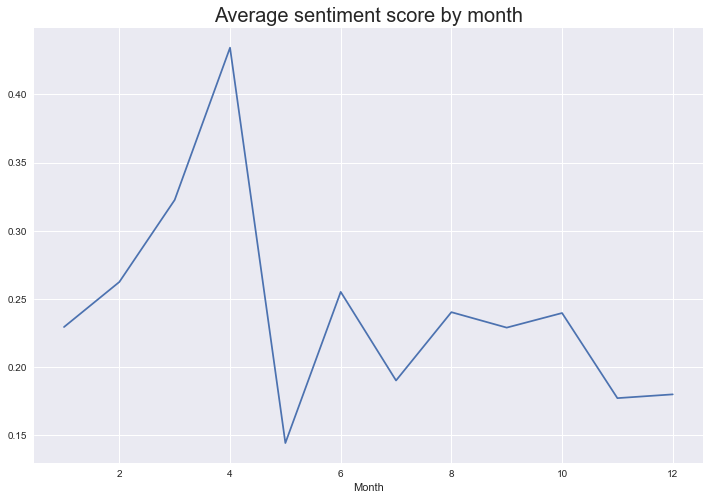

In [70]:
sns.set()
plt.figure(figsize=(12,8))
plt.title('Average sentiment score by month',fontsize=20)
a= bankA.groupby(['Month'])['SA'].mean().plot()
plt.show()

From the chart above, we can see that April has the highest average sentiment scores -- People seem to talk more positively in April than any other months, with aroung November and December the lowest score (might because of the message number is larger). The increasing trend from January to April might because of the influence of the end of the Fiscal year, the decreasing trend from April to May might because of the start of Fiscal year.

In [73]:
b =bankA.groupby(['Month','SA'])['SA'].count()
df = pd.DataFrame(b,columns=['Month','SA']).unstack()['SA']

In [74]:
df.head()

SA,-1,0,1
Month,,,
1,718,875,1406
2,516,654,1116
3,261,427,713
4,185,392,770
5,139,143,210


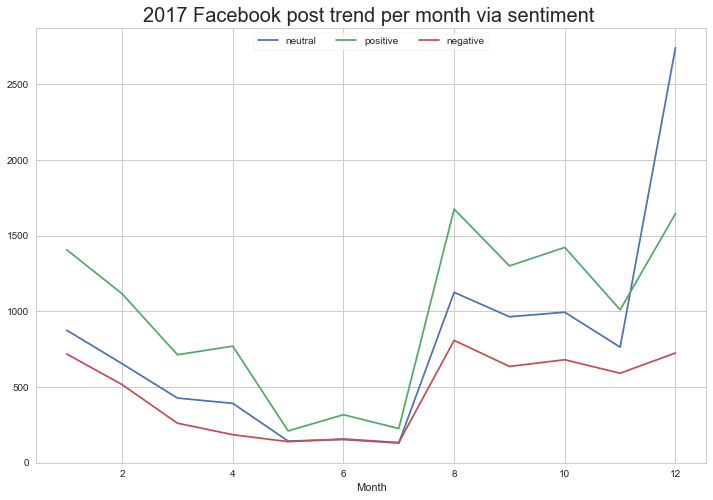

In [84]:
plt.figure(figsize=(12,8))
plt.title('2017 Facebook post trend per month via sentiment ',fontsize=20)
sns.set(style="whitegrid")
df[0].plot()
df[1].plot()
df[-1].plot()
plt.legend(('neutral', 'positive','negative'), loc='upper center', ncol=3, frameon=True, facecolor='white')

From the chart above, we can clearly see that, overall, banks have more positive messages and less negative messages. However, from November to December, there is an increasing trend of neutral messages. That might attribute to holidays and people's more visits to banks during that time of the year. 



Overall, as we can see from the wordclouds and several other plots above, credit card, financial service time at branches, and customer services are very popular topics discussed online. Banks should pay extreme attention to those services as they are the drivers of online financial conversation. We can also draw a conclusion that, most banks have a positive image online, with some negative discussions among topics like credit card and branch services.

#### As a public sentiment mornitoring agency, we strongly suggest banks to improve their customer service in order to maintain a positive image on social media. Also, branch waiting time should be reduced and service quality should be improved to reduce negative reviews on social media such as Facebook. By doing so, banks could have a better reputation on social media.

